# Практическое задание: Методы градиентного спуска и Ньютона

Реализация оракулов, методов оптимизации и эксперименты.

In [2]:
import numpy as np
import scipy
import scipy.sparse
import scipy.linalg
from scipy.special import expit
from scipy.optimize._linesearch import scalar_search_wolfe2
from numpy.linalg import LinAlgError
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

---
## 1. Оракулы (oracles.py)

In [3]:
class BaseSmoothOracle(object):
    def func(self, x):
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        raise NotImplementedError('Grad oracle is not implemented.')

    def hess(self, x):
        raise NotImplementedError('Hessian oracle is not implemented.')

    def func_directional(self, x, d, alpha):
        return np.squeeze(self.func(x + alpha * d))

    def grad_directional(self, x, d, alpha):
        return np.squeeze(self.grad(x + alpha * d).dot(d))

In [4]:
class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^T A x - b^T x.
    """
    def __init__(self, A, b):
        if not scipy.sparse.isspmatrix_dia(A) and not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.dot(self.A.dot(x), x) - self.b.dot(x)

    def grad(self, x):
        return self.A.dot(x) - self.b

    def hess(self, x):
        return self.A if isinstance(self.A, np.ndarray) else self.A.toarray()

In [5]:
class LogRegL2Oracle(BaseSmoothOracle):
    """
    Oracle for logistic regression with l2 regularization:
        func(x) = 1/m sum_i log(1 + exp(-b_i * a_i^T x)) + regcoef/2 ||x||^2
    """
    def __init__(self, matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef):
        self.matvec_Ax = matvec_Ax
        self.matvec_ATx = matvec_ATx
        self.matmat_ATsA = matmat_ATsA
        self.b = b
        self.regcoef = regcoef
        self.m = b.shape[0]

    def func(self, x):
        Ax = self.matvec_Ax(x)
        margins = -self.b * Ax
        # log(1 + exp(z)) computed stably via logaddexp
        loss = np.mean(np.logaddexp(0, margins))
        reg = self.regcoef / 2.0 * np.dot(x, x)
        return loss + reg

    def grad(self, x):
        Ax = self.matvec_Ax(x)
        margins = -self.b * Ax
        # sigma(-b * Ax) = 1/(1 + exp(b * Ax)) = expit(-b*Ax)
        sigma = expit(margins)
        # grad = -1/m * A^T (b * sigma) + regcoef * x
        # но sigma = expit(-b*Ax), и нам нужно -b * sigma
        grad_loss = -self.matvec_ATx(self.b * sigma) / self.m
        return grad_loss + self.regcoef * x

    def hess(self, x):
        Ax = self.matvec_Ax(x)
        margins = -self.b * Ax
        sigma = expit(margins)
        # diag weights: sigma * (1 - sigma)
        s = sigma * (1 - sigma)
        hess_loss = self.matmat_ATsA(s) / self.m
        n = x.shape[0]
        return hess_loss + self.regcoef * np.eye(n)

In [6]:
class LogRegL2OptimizedOracle(LogRegL2Oracle):
    """
    Optimized oracle with caching of Ax, Ad.
    """
    def __init__(self, matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef):
        super().__init__(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)
        self._x = None
        self._Ax = None
        self._d = None
        self._Ad = None
        self._last_x = None
        self._last_Ax = None

    def _get_Ax(self, x):
        if self._last_x is not None and np.array_equal(x, self._last_x):
            self._x = x.copy()
            self._Ax = self._last_Ax.copy()
            return self._Ax
        if self._x is None or not np.array_equal(x, self._x):
            self._x = x.copy()
            self._Ax = self.matvec_Ax(x)
        return self._Ax

    def _get_Ad(self, d):
        if self._d is None or not np.array_equal(d, self._d):
            self._d = d.copy()
            self._Ad = self.matvec_Ax(d)
        return self._Ad

    def func(self, x):
        Ax = self._get_Ax(x)
        margins = -self.b * Ax
        loss = np.mean(np.logaddexp(0, margins))
        return loss + self.regcoef / 2.0 * np.dot(x, x)

    def grad(self, x):
        Ax = self._get_Ax(x)
        margins = -self.b * Ax
        sigma = expit(margins)
        return -self.matvec_ATx(self.b * sigma) / self.m + self.regcoef * x

    def hess(self, x):
        Ax = self._get_Ax(x)
        margins = -self.b * Ax
        sigma = expit(margins)
        s = sigma * (1 - sigma)
        return self.matmat_ATsA(s) / self.m + self.regcoef * np.eye(x.shape[0])

    def func_directional(self, x, d, alpha):
        Ax = self._get_Ax(x)
        Ad = self._get_Ad(d)
        Axd = Ax + alpha * Ad
        self._last_x = x + alpha * d
        self._last_Ax = Axd
        margins = -self.b * Axd
        loss = np.mean(np.logaddexp(0, margins))
        xd = x + alpha * d
        return loss + self.regcoef / 2.0 * np.dot(xd, xd)

    def grad_directional(self, x, d, alpha):
        Ax = self._get_Ax(x)
        Ad = self._get_Ad(d)
        Axd = Ax + alpha * Ad
        self._last_x = x + alpha * d
        self._last_Ax = Axd
        margins = -self.b * Axd
        sigma = expit(margins)
        xd = x + alpha * d
        grad_at_xd = -self.matvec_ATx(self.b * sigma) / self.m + self.regcoef * xd
        return np.squeeze(grad_at_xd.dot(d))

In [7]:
def create_log_reg_oracle(A, b, regcoef, oracle_type='usual'):
    if scipy.sparse.issparse(A):
        matvec_Ax = lambda x: A.dot(x)
        matvec_ATx = lambda x: A.T.dot(x)
        def matmat_ATsA(s):
            S_half = scipy.sparse.diags(np.sqrt(s))
            AS = S_half.dot(A)
            return AS.T.dot(AS)
    else:
        matvec_Ax = lambda x: A.dot(x)
        matvec_ATx = lambda x: A.T.dot(x)
        def matmat_ATsA(s):
            return A.T.dot(A * s.reshape(-1, 1))

    if oracle_type == 'usual':
        return LogRegL2Oracle(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)
    elif oracle_type == 'optimized':
        return LogRegL2OptimizedOracle(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)
    else:
        raise ValueError('Unknown oracle_type=%s' % oracle_type)

In [8]:
def grad_finite_diff(func, x, eps=1e-8):
    n = x.shape[0]
    g = np.zeros(n)
    f0 = func(x)
    for i in range(n):
        ei = np.zeros(n)
        ei[i] = 1.0
        g[i] = (func(x + eps * ei) - f0) / eps
    return g


def hess_finite_diff(func, x, eps=1e-5):
    n = x.shape[0]
    H = np.zeros((n, n))
    f0 = func(x)
    for i in range(n):
        ei = np.zeros(n)
        ei[i] = 1.0
        for j in range(n):
            ej = np.zeros(n)
            ej[j] = 1.0
            H[i, j] = (func(x + eps*ei + eps*ej) - func(x + eps*ei) - func(x + eps*ej) + f0) / eps**2
    return H

### Проверка оракулов

In [9]:
# Проверка QuadraticOracle
A = np.eye(3)
b = np.array([1, 2, 3])
qo = QuadraticOracle(A, b)
x = np.zeros(3)
print(f'func(0) = {qo.func(x)} (ожидается 0.0)')
print(f'grad(0) = {qo.grad(x)} (ожидается [-1,-2,-3])')

# Проверка LogRegL2Oracle
A_lr = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
b_lr = np.array([1, 1, -1, 1])
logreg = create_log_reg_oracle(A_lr, b_lr, 0.5)
x = np.zeros(2)
print(f'\nLogReg func(0) = {logreg.func(x):.9f} (ожидается 0.693147180)')
print(f'LogReg grad(0) = {logreg.grad(x)} (ожидается [0, -0.25])')
print(f'LogReg hess(0) = ')
print(logreg.hess(x))
print('(ожидается [[0.625, 0.0625], [0.0625, 0.625]])')

# Проверка конечных разностей
g_fd = grad_finite_diff(qo.func, np.zeros(3))
print(f'\ngrad_finite_diff = {g_fd} (ожидается [-1,-2,-3])')

H_fd = hess_finite_diff(qo.func, np.zeros(3))
print(f'hess_finite_diff:\n{H_fd}\n(ожидается единичная матрица)')

func(0) = 0.0 (ожидается 0.0)
grad(0) = [-1. -2. -3.] (ожидается [-1,-2,-3])

LogReg func(0) = 0.693147181 (ожидается 0.693147180)
LogReg grad(0) = [ 0.   -0.25] (ожидается [0, -0.25])
LogReg hess(0) = 
[[0.625  0.0625]
 [0.0625 0.625 ]]
(ожидается [[0.625, 0.0625], [0.0625, 0.625]])

grad_finite_diff = [-1.         -1.99999999 -3.        ] (ожидается [-1,-2,-3])
hess_finite_diff:
[[ 1.00000000e+00  0.00000000e+00  3.38813179e-11]
 [-1.69406589e-11  1.00000000e+00 -3.38813179e-11]
 [ 1.69406589e-11 -3.38813179e-11  1.00000000e+00]]
(ожидается единичная матрица)


---
## 2. Оптимизация (optimization.py)

In [10]:
class LineSearchTool(object):
    def __init__(self, method='Wolfe', **kwargs):
        self._method = method
        if self._method == 'Wolfe':
            self.c1 = kwargs.get('c1', 1e-4)
            self.c2 = kwargs.get('c2', 0.9)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Armijo':
            self.c1 = kwargs.get('c1', 1e-4)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Constant':
            self.c = kwargs.get('c', 1.0)
        else:
            raise ValueError('Unknown method {}'.format(method))

    @classmethod
    def from_dict(cls, options):
        if type(options) != dict:
            raise TypeError('LineSearchTool initializer must be of type dict')
        return cls(**options)

    def to_dict(self):
        return self.__dict__

    def line_search(self, oracle, x_k, d_k, previous_alpha=None):
        if self._method == 'Constant':
            return self.c

        phi = lambda a: oracle.func_directional(x_k, d_k, a)
        dphi = lambda a: oracle.grad_directional(x_k, d_k, a)
        phi0 = phi(0)
        dphi0 = dphi(0)

        if self._method == 'Wolfe':
            alpha, _, _, _ = scalar_search_wolfe2(phi, dphi, phi0, None, dphi0,
                                                  c1=self.c1, c2=self.c2)
            if alpha is not None:
                return alpha
            # Fallback to Armijo backtracking
            alpha = self.alpha_0
        elif self._method == 'Armijo':
            if previous_alpha is not None:
                alpha = 2 * previous_alpha
            else:
                alpha = self.alpha_0

        # Armijo backtracking
        while phi(alpha) > phi0 + self.c1 * alpha * dphi0:
            alpha /= 2.0

        return alpha


def get_line_search_tool(line_search_options=None):
    if line_search_options:
        if type(line_search_options) is LineSearchTool:
            return line_search_options
        else:
            return LineSearchTool.from_dict(line_search_options)
    else:
        return LineSearchTool()

In [11]:
def _update_history(history, x, func_val, grad_norm, t0):
    if history is None:
        return
    history['func'].append(func_val)
    history['grad_norm'].append(grad_norm)
    history['time'].append(time.time() - t0)
    if x.size <= 2:
        history['x'].append(x.copy())


def gradient_descent(oracle, x_0, tolerance=1e-5, max_iter=10000,
                     line_search_options=None, trace=False, display=False):
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)
    t0 = time.time()

    grad_0 = oracle.grad(x_0)
    grad_0_norm_sq = np.dot(grad_0, grad_0)

    if grad_0_norm_sq == 0:
        _update_history(history, x_k, oracle.func(x_k), 0.0, t0)
        if display:
            print(f'Iter 0: f={oracle.func(x_k):.6f}, ||grad||={0.0:.6f}')
        return x_k, 'success', history

    prev_alpha = None

    for k in range(max_iter + 1):
        func_val = oracle.func(x_k)
        grad_k = oracle.grad(x_k)
        grad_norm = np.linalg.norm(grad_k)
        grad_norm_sq = np.dot(grad_k, grad_k)

        _update_history(history, x_k, func_val, grad_norm, t0)

        if display:
            print(f'Iter {k}: f={func_val:.6f}, ||grad||={grad_norm:.6f}')

        # Stopping criterion
        if grad_norm_sq <= tolerance * grad_0_norm_sq:
            return x_k, 'success', history

        if k == max_iter:
            return x_k, 'iterations_exceeded', history

        d_k = -grad_k
        alpha = line_search_tool.line_search(oracle, x_k, d_k, previous_alpha=prev_alpha)

        if alpha is None or not np.isfinite(alpha):
            return x_k, 'computational_error', history

        prev_alpha = alpha
        x_k = x_k + alpha * d_k

        if not np.all(np.isfinite(x_k)):
            return x_k, 'computational_error', history

    return x_k, 'iterations_exceeded', history

In [12]:
def newton(oracle, x_0, tolerance=1e-5, max_iter=100,
           line_search_options=None, trace=False, display=False):
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)
    t0 = time.time()

    grad_0 = oracle.grad(x_0)
    grad_0_norm_sq = np.dot(grad_0, grad_0)

    if grad_0_norm_sq == 0:
        _update_history(history, x_k, oracle.func(x_k), 0.0, t0)
        if display:
            print(f'Iter 0: f={oracle.func(x_k):.6f}, ||grad||={0.0:.6f}')
        return x_k, 'success', history

    for k in range(max_iter + 1):
        func_val = oracle.func(x_k)
        grad_k = oracle.grad(x_k)
        grad_norm = np.linalg.norm(grad_k)
        grad_norm_sq = np.dot(grad_k, grad_k)

        _update_history(history, x_k, func_val, grad_norm, t0)

        if display:
            print(f'Iter {k}: f={func_val:.6f}, ||grad||={grad_norm:.6f}')

        if grad_norm_sq <= tolerance * grad_0_norm_sq:
            return x_k, 'success', history

        if k == max_iter:
            return x_k, 'iterations_exceeded', history

        hess_k = oracle.hess(x_k)

        try:
            if hess_k.ndim == 0 or (hess_k.ndim == 1 and hess_k.size == 1):
                # 1D case
                h = float(hess_k)
                if h <= 0:
                    return x_k, 'newton_direction_error', history
                d_k = -grad_k / h
            else:
                cho = scipy.linalg.cho_factor(hess_k)
                d_k = scipy.linalg.cho_solve(cho, -grad_k)
        except LinAlgError:
            return x_k, 'newton_direction_error', history

        alpha = line_search_tool.line_search(oracle, x_k, d_k, previous_alpha=None)

        if alpha is None or not np.isfinite(alpha):
            return x_k, 'computational_error', history

        x_k = x_k + alpha * d_k

        if not np.all(np.isfinite(x_k)):
            return x_k, 'computational_error', history

    return x_k, 'iterations_exceeded', history

### Быстрая проверка

In [13]:
# Проверка на квадратичной функции f(x) = 1/2 x^T x - [1,2,3]^T x
oracle = QuadraticOracle(np.eye(3), np.array([1, 2, 3]))
x0 = np.ones(3) * 10.0

x_star, msg, hist = gradient_descent(oracle, x0, trace=True, max_iter=100)
print(f'GD: x* = {x_star}, msg = {msg}')

x_star, msg, hist = newton(oracle, x0, trace=True, max_iter=100,
                           line_search_options={'method': 'Constant', 'c': 1.0})
print(f'Newton: x* = {x_star}, msg = {msg}')

GD: x* = [1. 2. 3.], msg = success
Newton: x* = [1. 2. 3.], msg = success


---
## 3. Вспомогательные функции для рисования

In [14]:
def plot_levels(func, xrange=None, yrange=None, levels=None):
    if xrange is None: xrange = [-6, 6]
    if yrange is None: yrange = [-5, 5]
    if levels is None: levels = [0, 0.25, 1, 4, 9, 16, 25]
    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidths=1.5)
    plt.clabel(CS, inline=1, fontsize=8)
    plt.grid()

def plot_trajectory(func, history, label=None):
    x_values, y_values = zip(*history)
    plt.plot(x_values, y_values, '-v', linewidth=2.0, ms=8.0, alpha=0.8, label=label)

---
## Эксперимент 3.1: Траектория градиентного спуска на квадратичной функции

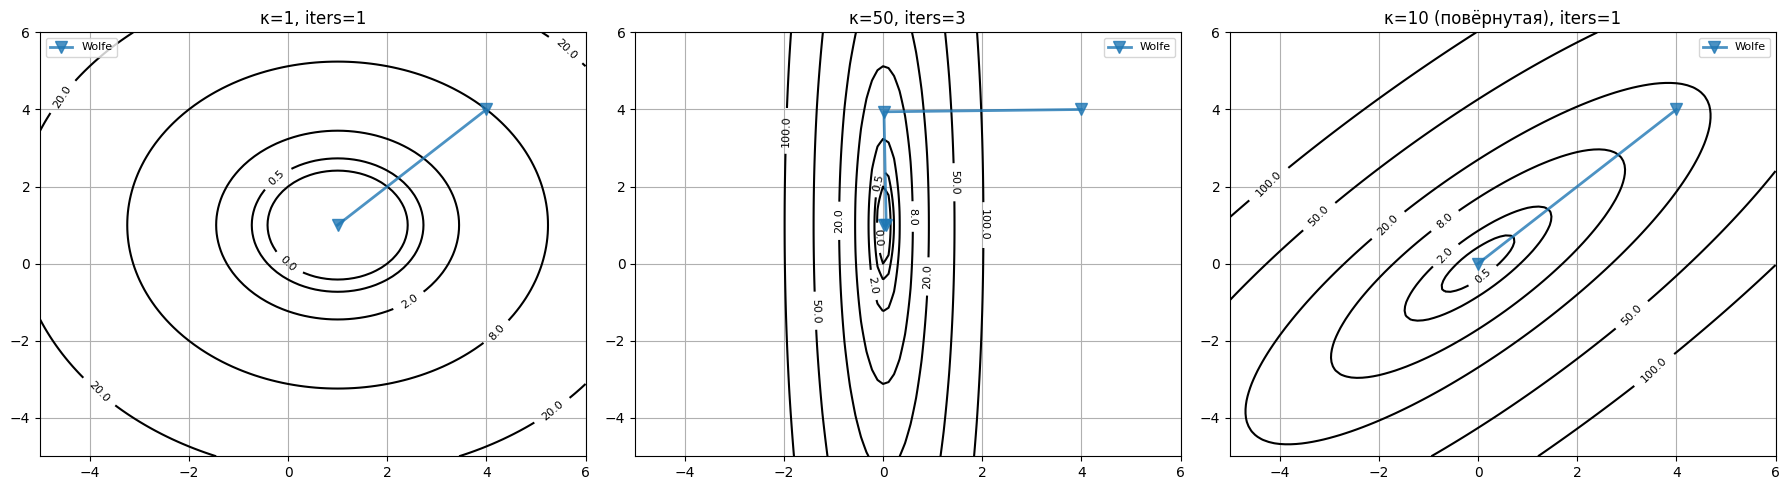

Вывод: при большем числе обусловленности метод делает больше итераций,
траектория "зигзагообразная". При κ=1 сходимость за 1 шаг.


In [15]:
# Хорошо обусловленная функция: kappa ~= 1
A1 = np.array([[1.0, 0.0], [0.0, 1.0]])
b1 = np.array([1.0, 1.0])
oracle1 = QuadraticOracle(A1, b1)

# Плохо обусловленная функция: kappa = 50
A2 = np.array([[50.0, 0.0], [0.0, 1.0]])
b2 = np.array([1.0, 1.0])
oracle2 = QuadraticOracle(A2, b2)

# Средняя обусловленность с поворотом: kappa = 10
theta = np.pi / 4
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
A3 = R.T @ np.diag([10.0, 1.0]) @ R
b3 = np.array([0.0, 0.0])
oracle3 = QuadraticOracle(A3, b3)

x0 = np.array([4.0, 4.0])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, oracle, title, kappa in zip(axes,
    [oracle1, oracle2, oracle3],
    ['κ=1', 'κ=50', 'κ=10 (повёрнутая)'],
    [1, 50, 10]):
    
    plt.sca(ax)
    plot_levels(oracle.func, xrange=[-5, 6], yrange=[-5, 6],
               levels=[0, 0.5, 2, 8, 20, 50, 100])
    
    x_star, msg, hist = gradient_descent(oracle, x0, trace=True, tolerance=1e-8,
                                         line_search_options={'method': 'Wolfe'})
    if 'x' in hist:
        plot_trajectory(oracle.func, hist['x'], label='Wolfe')
    
    ax.set_title(f'{title}, iters={len(hist["func"])-1}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

print('Вывод: при большем числе обусловленности метод делает больше итераций,')
print('траектория "зигзагообразная". При κ=1 сходимость за 1 шаг.')

### Сравнение стратегий выбора шага

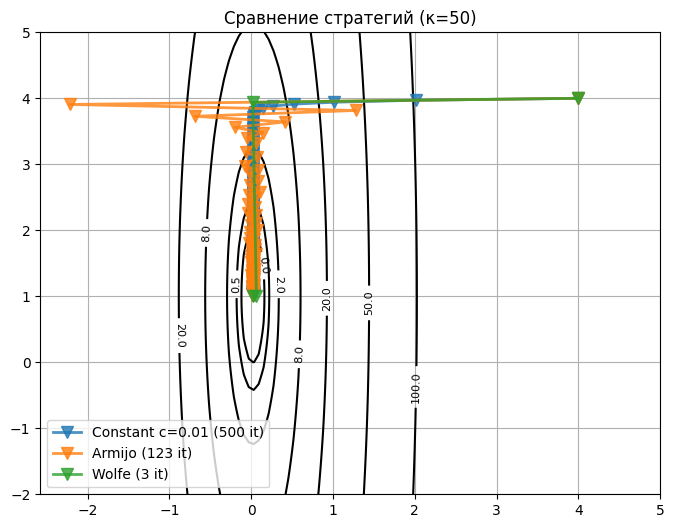

In [16]:
oracle = QuadraticOracle(A2, b2)
x0 = np.array([4.0, 4.0])

strategies = [
    ('Constant c=0.01', {'method': 'Constant', 'c': 0.01}),
    ('Armijo', {'method': 'Armijo', 'c1': 1e-4, 'alpha_0': 1.0}),
    ('Wolfe', {'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9}),
]

plt.figure(figsize=(8, 6))
plot_levels(oracle.func, xrange=[-1, 5], yrange=[-2, 5],
            levels=[0, 0.5, 2, 8, 20, 50, 100])

for name, opts in strategies:
    x_star, msg, hist = gradient_descent(oracle, x0, trace=True, tolerance=1e-8,
                                         line_search_options=opts)
    if hist and 'x' in hist:
        plot_trajectory(oracle.func, hist['x'], label=f'{name} ({len(hist["func"])-1} it)')

plt.legend()
plt.title('Сравнение стратегий (κ=50)')
plt.show()

---
## Эксперимент 3.2: Зависимость числа итераций от обусловленности и размерности

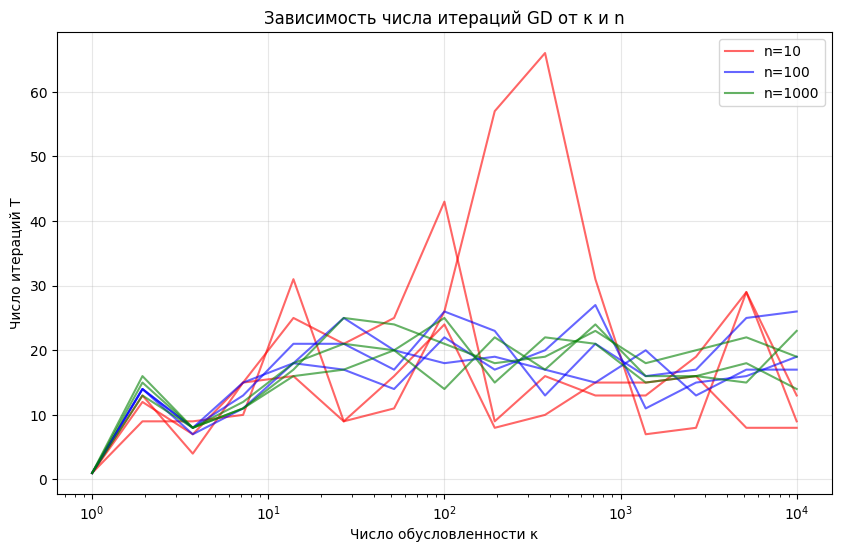

Вывод: число итераций растёт линейно с κ.
Зависимость от n слабая — при одном κ разные n дают схожее число итераций.


In [17]:
np.random.seed(42)

dims = [10, 100, 1000]
kappas = np.logspace(0, 4, 15)  # от 1 до 10000
n_repeats = 3
colors = ['red', 'blue', 'green']

plt.figure(figsize=(10, 6))

for n, color in zip(dims, colors):
    for rep in range(n_repeats):
        iters_list = []
        for kappa in kappas:
            # Генерируем диагональную матрицу с числом обусловленности kappa
            diag_vals = np.random.uniform(1, kappa, n)
            diag_vals[0] = 1.0
            diag_vals[-1] = kappa
            A = scipy.sparse.diags(diag_vals)
            b_vec = np.random.randn(n)
            oracle = QuadraticOracle(A, b_vec)
            x0 = np.random.randn(n)
            
            x_star, msg, hist = gradient_descent(
                oracle, x0, tolerance=1e-5, max_iter=50000,
                line_search_options={'method': 'Wolfe'},
                trace=True
            )
            iters_list.append(len(hist['func']) - 1)
        
        label = f'n={n}' if rep == 0 else None
        plt.plot(kappas, iters_list, color=color, alpha=0.6, label=label)

plt.xscale('log')
plt.xlabel('Число обусловленности κ')
plt.ylabel('Число итераций T')
plt.title('Зависимость числа итераций GD от κ и n')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('Вывод: число итераций растёт линейно с κ.')
print('Зависимость от n слабая — при одном κ разные n дают схожее число итераций.')

---
## Эксперимент 3.3: Сравнение GD и Newton на логистической регрессии

Используем модельные данные (т.к. скачивание LIBSVM может быть недоступно).

In [18]:
# Попробуем загрузить реальные данные, если не получится — используем модельные
try:
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
    from sklearn.datasets import load_svmlight_file
    import urllib.request
    import os
    
    if not os.path.exists('w8a'):
        url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a'
        req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        with open('w8a', 'wb') as f:
            f.write(urllib.request.urlopen(req, timeout=10).read())
    
    A_real, b_real = load_svmlight_file('w8a')
    b_real[b_real == 0] = -1  # ensure labels are -1/+1
    dataset_name = 'w8a'
    print(f'Загружен {dataset_name}: A={A_real.shape}')
    USE_REAL = True
except Exception as e:
    print(f'Не удалось загрузить данные: {e}')
    print('Используем модельные данные')
    USE_REAL = False
    np.random.seed(31415)
    m, n = 2000, 300
    A_real = np.random.randn(m, n)
    b_real = np.sign(np.random.randn(m))
    dataset_name = 'model (2000x300)'

Загружен w8a: A=(49749, 300)


In [19]:
m = A_real.shape[0]
regcoef = 1.0 / m

oracle_gd = create_log_reg_oracle(A_real, b_real, regcoef, oracle_type='usual')

if scipy.sparse.issparse(A_real):
    n_feat = A_real.shape[1]
else:
    n_feat = A_real.shape[1]

x0 = np.zeros(n_feat)

print(f'Датасет: {dataset_name}, m={m}, n={n_feat}, lambda={regcoef:.6f}')

# Gradient descent
print('\nЗапуск GD...')
x_gd, msg_gd, hist_gd = gradient_descent(
    oracle_gd, x0, tolerance=1e-5, max_iter=500,
    line_search_options={'method': 'Wolfe'}, trace=True
)
print(f'GD: {msg_gd}, iters={len(hist_gd["func"])-1}')

# Newton (только для небольших данных)
if n_feat <= 1000:
    oracle_nt = create_log_reg_oracle(A_real, b_real, regcoef, oracle_type='usual')
    print('\nЗапуск Newton...')
    x_nt, msg_nt, hist_nt = newton(
        oracle_nt, x0, tolerance=1e-5, max_iter=100,
        line_search_options={'method': 'Wolfe'}, trace=True
    )
    print(f'Newton: {msg_nt}, iters={len(hist_nt["func"])-1}')
    run_newton = True
else:
    print('\nNewton пропущен (n слишком большое для O(n^3) гессиана)')
    run_newton = False

Датасет: w8a, m=49749, n=300, lambda=0.000020

Запуск GD...
GD: success, iters=35

Запуск Newton...
Newton: success, iters=6


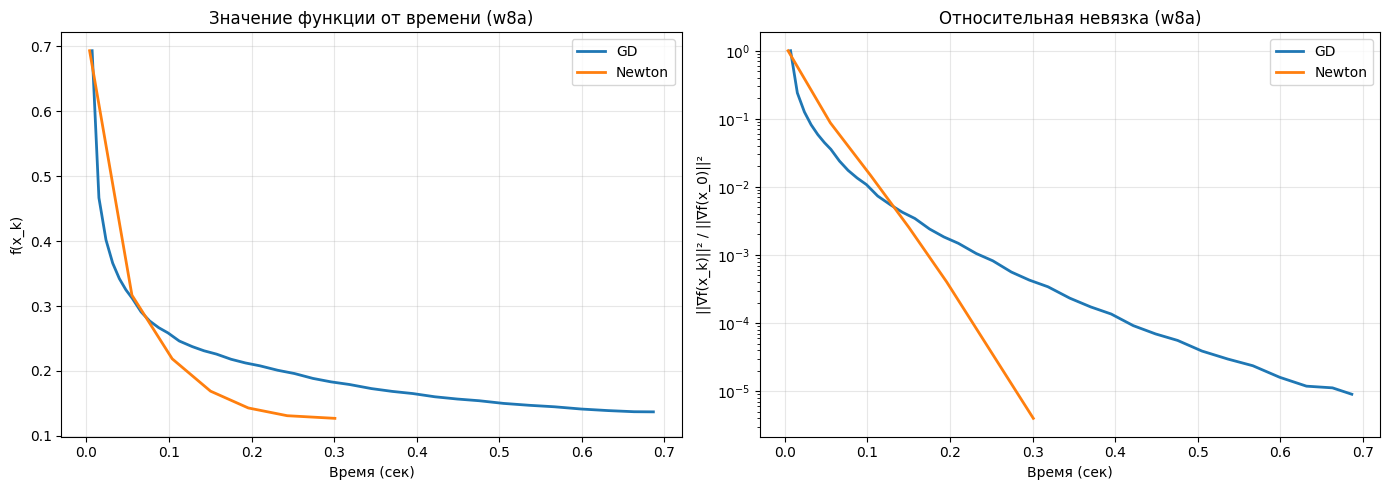

Стоимость итерации GD:     O(mn) — одно матрично-векторное произведение
Стоимость итерации Newton:  O(mn² + n³) — гессиан + Холецкий
Память GD:     O(mn)
Память Newton: O(mn + n²)

Вывод: Newton сходится за меньше итераций, но каждая итерация дороже.
Для малых n Newton быстрее, для больших n GD предпочтительнее.


In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# (a) Функция от времени
ax1.plot(hist_gd['time'], hist_gd['func'], label='GD', linewidth=2)
if run_newton:
    ax1.plot(hist_nt['time'], hist_nt['func'], label='Newton', linewidth=2)
ax1.set_xlabel('Время (сек)')
ax1.set_ylabel('f(x_k)')
ax1.set_title(f'Значение функции от времени ({dataset_name})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# (b) Относительная норма градиента от времени
gd_rel = np.array(hist_gd['grad_norm']) ** 2 / hist_gd['grad_norm'][0] ** 2
ax2.plot(hist_gd['time'], gd_rel, label='GD', linewidth=2)
if run_newton:
    nt_rel = np.array(hist_nt['grad_norm']) ** 2 / hist_nt['grad_norm'][0] ** 2
    ax2.plot(hist_nt['time'], nt_rel, label='Newton', linewidth=2)
ax2.set_yscale('log')
ax2.set_xlabel('Время (сек)')
ax2.set_ylabel('||∇f(x_k)||² / ||∇f(x_0)||²')
ax2.set_title(f'Относительная невязка ({dataset_name})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Стоимость итерации GD:     O(mn) — одно матрично-векторное произведение')
print(f'Стоимость итерации Newton:  O(mn² + n³) — гессиан + Холецкий')
print(f'Память GD:     O(mn)')
print(f'Память Newton: O(mn + n²)')
print(f'\nВывод: Newton сходится за меньше итераций, но каждая итерация дороже.')
print(f'Для малых n Newton быстрее, для больших n GD предпочтительнее.')

---
## Проверка разностными производными

In [21]:
# Проверка градиента и гессиана на модельных данных
np.random.seed(42)
A_test = np.random.randn(20, 5)
b_test = np.sign(np.random.randn(20))
oracle_test = create_log_reg_oracle(A_test, b_test, 0.1)

for _ in range(3):
    x_test = np.random.randn(5)
    
    g_analytic = oracle_test.grad(x_test)
    g_numeric = grad_finite_diff(oracle_test.func, x_test)
    
    H_analytic = oracle_test.hess(x_test)
    H_numeric = hess_finite_diff(oracle_test.func, x_test)
    
    print(f'||grad_analytic - grad_numeric|| = {np.linalg.norm(g_analytic - g_numeric):.2e}')
    print(f'||hess_analytic - hess_numeric|| = {np.linalg.norm(H_analytic - H_numeric):.2e}')
    print()

||grad_analytic - grad_numeric|| = 2.02e-08
||hess_analytic - hess_numeric|| = 1.68e-05

||grad_analytic - grad_numeric|| = 4.99e-08
||hess_analytic - hess_numeric|| = 1.44e-05

||grad_analytic - grad_numeric|| = 4.28e-08
||hess_analytic - hess_numeric|| = 1.29e-05



---
## Выводы

1. **Градиентный спуск** прост в реализации, стоимость итерации O(mn). Число итераций растёт линейно с числом обусловленности κ. Зависимость от размерности n слабая.

2. **Метод Ньютона** сходится квадратично вблизи оптимума, но каждая итерация стоит O(mn² + n³) и требует O(n²) дополнительной памяти для гессиана.

3. **Стратегии линейного поиска**: Wolfe обычно даёт лучшие результаты, Armijo — надёжный fallback, константный шаг требует аккуратного подбора.

4. **Оракул логистической регрессии** требует аккуратной реализации для численной стабильности (logaddexp, expit вместо прямого exp).

5. Newton выгоднее при малом n и большом κ, GD — при большом n.